In [18]:
import sys

sys.path.append('/mnt/sdceph/users/nroy/radmc3d-2.0/python/radmc3dPy')
sys.path.append('/mnt/home/nroy/test/chimes-IGNIS/chimes-driver/ext-lib/pfh_python')

#from simpleplot import *
#from radmc3dPy import image
#from gizmopy.load_from_snapshot import load_from_snapshot
#from gizmopy.load_fire_snap import load_fire_snap
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.facecolor']='w'


params = {"text.color" : 'k',
          "ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}

plt.rcParams.update(params)

'''
for generalization, see "#CHANGE" throughout code on lines where needs change depending on emission line instance (ctrl+f tofind and change quickly), most changes should be covered by changing the parent variable below.
''';

In [23]:
''' to create "intrinsic" v/sigma number for emission lines, take moment 1 of edge on view, 
then take moment 2 of face on view, 
and perform v/sigma calc with these 2 arrays for every emission line. 
TEST '''

faceon_m12i_HI = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/0deg/Halpha/HI/"
edgeon_m12i_HI = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/90deg/Halpha/HI/"

faceon_m12i_HII = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/0deg/Halpha/HII/"
edgeon_m12i_HII = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/90deg/Halpha/HII/"

line = "Halpha"

In [24]:
''' MOMENT 1 FROM EDGE ON '''
filepath_tot = edgeon_m12i_HI + 'image_tot.hdf5'
filepath_con = edgeon_m12i_HI + 'image_continuum.hdf5'
file_con = h5.File(filepath_con,'r')
file_tot = h5.File(filepath_tot,'r')

npix_x = np.shape(file_tot['image_array'][:])[0]
npix_y = np.shape(file_tot['image_array'][:])[1]

image_array = file_tot['image_array'][:] - file_con['image_array'][:]

image_array[image_array < 0] = 0

frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

filepath_tot_2 = edgeon_m12i_HII + 'image_tot.hdf5'
filepath_con_2 = edgeon_m12i_HII + 'image_continuum.hdf5'
file_con_2 = h5.File(filepath_con,'r')
file_tot_2 = h5.File(filepath_tot,'r')

npix_x_2 = np.shape(file_tot_2['image_array'][:])[0]
npix_y_2 = np.shape(file_tot_2['image_array'][:])[1]

image_array_2 = file_tot_2['image_array'][:] - file_con_2['image_array'][:]

image_array_2[image_array_2 < 0] = 0

frequency_array_2 = 3e8 / (file_tot_2['lambda_array'][:] * 1e-6)

image_array = image_array + image_array_2


#moment 0
integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

integrated_image_array_moment0[0,0] = 0 #final moment 0 array
moment_0_edge = np.asarray(integrated_image_array_moment0) 

#moment 1
lambda_0_dict = {"CII_158mu": 157.62730407714844,
     "Halpha": 0.65600490570068359, 
     "NII_6548A": 0.6545339822769165,
     "OI_6300A": 0.62976968288421631,
     "NII_6585A": 0.65807253122329712,
     "OI_63mu": 63.141555786132812,
     "OI_145mu": 145.43453979492188,
     "OIII_5007A": 0.50047838687896729,
     "OIII_88mu": 88.295417785644531,
     "OIV_25mu": 25.87542724609375,
     "NeII_12mu": 12.804655075073242,
     "NeIII_15mu": 15.543784141540527,
     "NeIII_3869A" : 0.3867171793754335,
     "NeV_14mu": 14.316787719726562,
     "NeV_3426A" : 0.34246401541369015,
     "NeVI_7mu": 7.6469192504882812,
     "SII_6716A": 0.67136573791503906,
     "SII_6731A": 0.67280274629592896,
     "SIII_18mu": 18.69268798828125,
     "CO_J10": 2600.757634}

lambda_0 = lambda_0_dict[line]
lambda_array = np.array(file_con['lambda_array'])
velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


moment1_noint = velocity_arr * image_array

integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
isolate_moment_1[0,0] = 0 #final moment 1 array
moment_1 = np.asarray(isolate_moment_1) 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


In [25]:
''' MOMENT 2 FROM FACE ON '''
filepath_tot = faceon_m12i_HI + 'image_tot.hdf5'
filepath_con = faceon_m12i_HI + 'image_continuum.hdf5'
file_con = h5.File(filepath_con,'r')
file_tot = h5.File(filepath_tot,'r')

npix_x = np.shape(file_tot['image_array'][:])[0]
npix_y = np.shape(file_tot['image_array'][:])[1]

image_array = file_tot['image_array'][:] - file_con['image_array'][:]

image_array[image_array < 0] = 0

frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

filepath_tot_2 = faceon_m12i_HII + 'image_tot.hdf5'
filepath_con_2 = faceon_m12i_HII + 'image_continuum.hdf5'
file_con_2 = h5.File(filepath_con,'r')
file_tot_2 = h5.File(filepath_tot,'r')

npix_x_2 = np.shape(file_tot_2['image_array'][:])[0]
npix_y_2 = np.shape(file_tot_2['image_array'][:])[1]

image_array_2 = file_tot_2['image_array'][:] - file_con_2['image_array'][:]

image_array_2[image_array_2 < 0] = 0

frequency_array_2 = 3e8 / (file_tot_2['lambda_array'][:] * 1e-6)

image_array = image_array + image_array_2

#moment 0
integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

integrated_image_array_moment0[0,0] = 0 #final moment 0 array
moment_0_face = np.asarray(integrated_image_array_moment0) 

#moment 1
lambda_0_dict = {"CII_158mu": 157.62730407714844,
     "Halpha": 0.65600490570068359, 
     "NII_6548A": 0.6545339822769165,
     "OI_6300A": 0.62976968288421631,
     "OI_63mu": 63.141555786132812,
     "NII_6585A": 0.65807253122329712,
     "OI_145mu": 145.43453979492188,
     "OIII_5007A": 0.50047838687896729,
     "OIII_88mu": 88.295417785644531,
     "OIV_25mu": 25.87542724609375,
     "NeII_12mu": 12.804655075073242,
     "NeIII_15mu": 15.543784141540527,
     "NeIII_3869A" : 0.3867171793754335,
     "NeV_14mu": 14.316787719726562,
     "NeV_3426A" : 0.34246401541369015,
     "NeVI_7mu": 7.6469192504882812,
     "SII_6716A": 0.67136573791503906,
     "SII_6731A": 0.67280274629592896,
     "SIII_18mu": 18.69268798828125,
     "CO_J10": 2600.757634}

lambda_0 = lambda_0_dict[line]
lambda_array = np.array(file_con['lambda_array'])
velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


moment1_noint = velocity_arr * image_array

integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
isolate_moment_1[0,0] = 0 #final moment 1 array

#moment 2
isolate_moment_1_3D = np.empty([len(image_array), len(image_array), len(velocity_arr)])

for i in range(len(velocity_arr)):
    for j in range(len(image_array)):
        for k in range(len(image_array)):
            isolate_moment_1_3D[j][k][i] = isolate_moment_1[j][k]

moment2_noint = image_array * ((velocity_arr - isolate_moment_1_3D) * (velocity_arr - isolate_moment_1_3D))

integrated_image_array_moment2 = np.zeros((npix_x, npix_y))

for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment2[i, j] = np.sum(delta_nu * (moment2_noint[i, j, :-1] + moment2_noint[i, j, 1:]) / 2.0)

integrated_image_array_moment2[0,0] = 0

isolate_moment_2 = integrated_image_array_moment2 / integrated_image_array_moment0
isolate_moment_2[0,0] = 0

isolate_moment_2 = np.sqrt(isolate_moment_2) #final moment 2 array
moment_2 = np.asarray(isolate_moment_2) 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


In [26]:
''' CALC V/SIGMA '''
numerator = moment_0_edge * ((moment_1)*(moment_1))
denominator = moment_0_face * ((moment_2)*(moment_2))

#NaN Catcher
if np.isnan(np.sum(numerator)):
    numerator[np.where(np.isnan(numerator))] = 0
if np.isnan(np.sum(denominator)):
    denominator[np.where(np.isnan(denominator))] = 0

v_sigma_sq = (np.sum(numerator))/(np.sum(denominator))
v_sigma = np.sqrt(v_sigma_sq)

v_sigma

1.4734532249541967

In [27]:
CII_intrinsic_vsigma = 7.688
OIII_intrinsic_vsigma = 2.416
NII_intrinsic_vsigma = 3.821
CO_intrinsic_vsigma = 8.140
Halpha_intrinsic_vsigma = 1.473

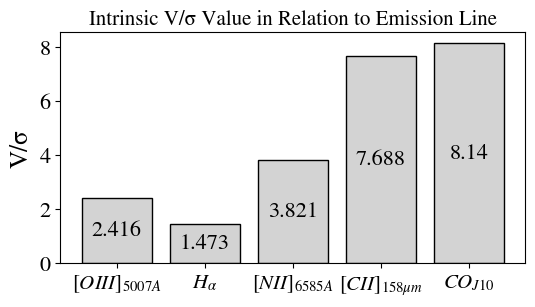

In [30]:
x_axis = [r'$[OIII]_{5007A}$', r'$H_{\alpha}$', r'$[NII]_{6585A}$', r'$[CII]_{158{\mu}m}$', r'$CO_{J10}$'] #snapshots

y_axis = [OIII_intrinsic_vsigma, Halpha_intrinsic_vsigma, NII_intrinsic_vsigma, CII_intrinsic_vsigma, CO_intrinsic_vsigma] #values

fig, ax = plt.subplots(figsize = (6, 3))
barplot = ax.bar(x = x_axis, height = y_axis, fc = "lightgray", ec = "black")
ax.bar_label(barplot, labels = y_axis, label_type = "center", fontsize = 16)

#for index, value in enumerate(y_axis):
   # plt.text(value, index, str(value))
plt.yticks(fontsize=16)
plt.xticks(fontsize=15)
plt.title('Intrinsic V/σ Value in Relation to Emission Line', fontsize = 15) #change
plt.xlabel('', fontsize = 18)
plt.ylabel('V/σ', fontsize = 18)
plt.show()